#### Set experiment parameters in config
For training that terminates in a reasonable timeframe use data in sample_subset/audio.
This is not a real dataset as it consists of 10 images, but the functionality of the code can be examined.
The full dataset can be found here "https://magenta.withgoogle.com/datasets/nsynth#files" It must first be extracted, for example with the function in data_work.ipynb. To use the full dataset, preprocessing is recommend. A function for this purpose can also be found in the data_work notebook. To continue with the experiment, set the parameters of the config to something reasonable for your hardware like done bewlow:

In [1]:
from config import load_config
config = load_config()
#Set folder to sample dataset for prototyping
#config.data.train_audio_folder = 'data/sample_subset/audio'
#config.data.test_audio_folder = 'data/sample_subset/audio'
config.vae.batch_size = 256
config.vae.epochs = 50

In [2]:
from train_vae import train, test
from datasets import HDF5SpectrogramDataset, collate_fn, SpectogramDataset
from VAE_models import VAE, CVAE, count_parameters, save_checkpoint

from datetime import datetime
import os

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch

conv = True
train_data = HDF5SpectrogramDataset('data/train_spectrograms_even.h5')
test_data = HDF5SpectrogramDataset('data/valid_spectrograms_even.h5')

train_loader = DataLoader(train_data, batch_size=config.vae.batch_size, shuffle=True, pin_memory=True, num_workers=8, persistent_workers=True, prefetch_factor=2)
test_loader = DataLoader(test_data, batch_size=config.vae.batch_size, shuffle=False, pin_memory=True, num_workers=4, persistent_workers=True)

sample_spec = train_data[0] # Sample spectogram 
in_dim = sample_spec.numel() # For spectograms = width * height
image_size = tuple(sample_spec.size())

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join(config.log_dir, timestamp)
os.makedirs(log_dir, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

if conv:
    model = CVAE([128, 172], config.vae.latent_dim, config.vae.beta_kl).to(device)
else:
    model = VAE(in_dim, config.vae.latent_dim, config.vae.n_layers, config.vae.beta_kl).to(device)

print(count_parameters(model))

torch.set_float32_matmul_precision("medium")
#model = torch.compile(model, mode="max-autotune")

optimizer = torch.optim.Adam(model.parameters(), lr=config.vae.lr, weight_decay=config.vae.weight_decay)
writer = SummaryWriter(log_dir)
prev_updates = 0
best_loss = torch.tensor(float('Inf'))
for epoch in range(config.vae.epochs):
    print(f'Epoch {epoch+1}/{config.vae.epochs}')
    prev_updates = train(model, train_loader, optimizer, prev_updates, config, device=device, writer=writer, conv=conv)
    test_loss = test(model, test_loader, prev_updates, config, device, writer=writer, conv=True)
    if test_loss < best_loss:
        best_loss = test_loss
        if conv:
            save_checkpoint(model, optimizer, epoch, test_loss, config, conv, image_size)
        else:
            save_checkpoint(model, optimizer, epoch, test_loss, config, conv, in_dim)
    


cuda
8881153
Epoch 1/50


  0%|          | 5/1130 [00:02<06:07,  3.06it/s]

Step 0 (N samples: 0), Loss: 13642.7812 (Recon: 13642.0898, KL: 0.6914) Grad: inf


 45%|████▍     | 506/1130 [00:21<00:24, 24.99it/s]

Step 500 (N samples: 128,000), Loss: 4649.7554 (Recon: 4604.3027, KL: 45.4524) Grad: 8292.5078


 89%|████████▉ | 1004/1130 [00:42<00:05, 22.23it/s]

Step 1,000 (N samples: 256,000), Loss: 4349.0898 (Recon: 4299.1572, KL: 49.9324) Grad: 11963.5077


Testing: 100%|██████████| 50/50 [00:02<00:00, 18.90it/s]


====> Test set loss: 4579.3811 (BCE: 4529.8329, KLD: 49.5482)
Epoch 2/50


  5%|▍         | 52/1130 [00:02<00:55, 19.41it/s]


KeyboardInterrupt: 

#### Load model and decode random latent codes

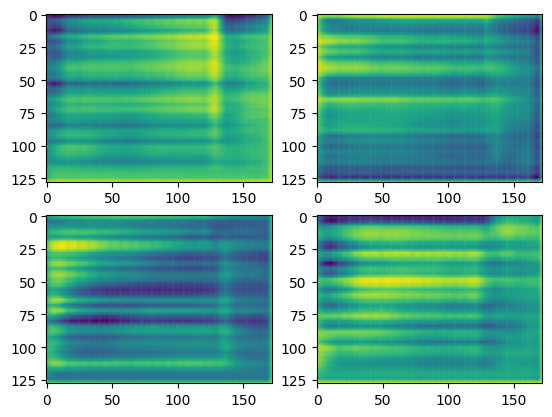

In [3]:
import matplotlib.pyplot as plt
import torch
from VAE_models import load_vae_model
conv = True
model, checkpoint = load_vae_model('models/conv_vae/c_vae_checkpoint_20250702-222022.pt', 'cuda', conv=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()

z = torch.randn(4, checkpoint['config']['latent_dim']).to(device)
with torch.no_grad():
    samples = model.decode(z)
samples = samples.cpu().view(4, 128, 172).numpy()
plt.figure()
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(samples[i])

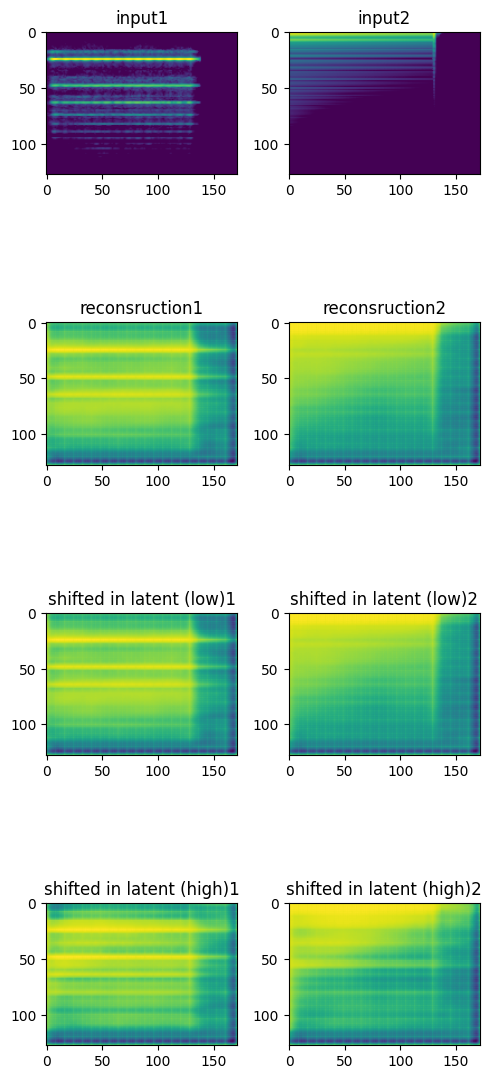

In [4]:
from datasets import HDF5SpectrogramDataset
from torch.utils.data import DataLoader
import numpy as np
num_samples = 2
train_data = HDF5SpectrogramDataset('data/train_spectrograms_even.h5')
train_loader = DataLoader(train_data, batch_size=num_samples, shuffle=True)

inputs = next(iter(train_loader))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inputs = inputs.to(device)
with torch.no_grad():
    if not conv:
        inputs = inputs.view(num_samples, -1)  # Flatten the data when not using convolutional VAE
    else:
        inputs = inputs.view(num_samples, 1, 128, 172)
    dist = model.encode(inputs)
    z_s = model.reparameterize(dist)
    recons = model.decode(z_s).cpu().view(num_samples, 128, 172).numpy()
    shifted_z_s_high = z_s + torch.rand_like(z_s) * 5.0
    shifted_z_s_low = z_s + torch.rand_like(z_s) * 000.1
    shifted_high = model.decode(shifted_z_s_high).cpu().view(num_samples, 128, 172).numpy()
    shifted_low = model.decode(shifted_z_s_low).cpu().view(num_samples, 128, 172).numpy()
    inputs = inputs.cpu().view(num_samples, 128, 172).numpy()
images = np.array([inputs, recons, shifted_high, shifted_low]).reshape((8, 128, 172))
plt.figure(figsize=[5,12])
for i in range(num_samples):
    plt.subplot(4,num_samples,i+1)
    plt.imshow(inputs[i])
    plt.title(f'input{i+1}')
    plt.subplot(4,num_samples,i+num_samples+1)
    plt.imshow(recons[i])
    plt.title(f'reconsruction{i+1}')
    plt.subplot(4,num_samples,i+2*num_samples+1)
    plt.imshow(shifted_low[i])
    plt.title(f'shifted in latent (low){i+1}')
    plt.subplot(4,num_samples,i+3*num_samples+1)
    plt.imshow(shifted_high[i])
    plt.title(f'shifted in latent (high){i+1}')
plt.tight_layout()

